/Users/rakibabdullah/Desktop/4-2/CSE472/ProjectML/code/DeepCMorph/model.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_checkpoints, ma

Model loaded, unexpected keys: []
Extracting feature vectors...
Feature vectors shape: (32, 2560)
Reducing dimensions...
Clustering with K-Means...
Visualizing clusters...


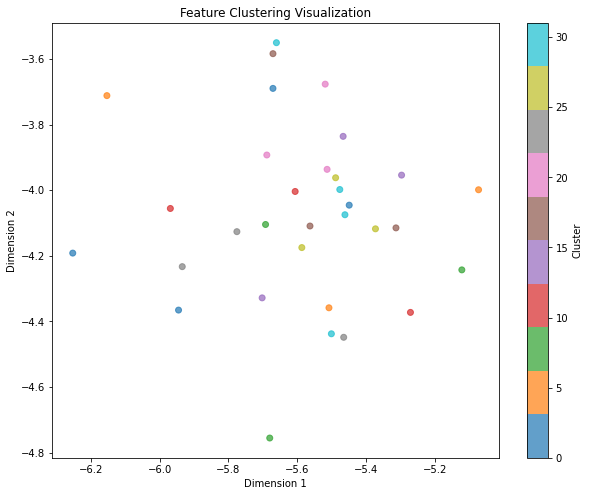

<Figure size 432x288 with 0 Axes>

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from model import DeepCMorph
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Setup the model
NUM_CLASSES = 32
PATH_TO_SAMPLE_FOLDER = "data/sample_TCGA_images/"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and load pre-trained weights
model = DeepCMorph(num_classes=NUM_CLASSES)
model.load_weights(dataset="TCGA")  # Use the TCGA dataset
model.to(DEVICE)
model.eval()

# Step 2: Load test images
test_transforms = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(PATH_TO_SAMPLE_FOLDER, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Step 3: Extract feature vectors
print("Extracting feature vectors...")
feature_vectors = []
labels = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to(DEVICE)
        features = model(images, return_features=True)  # Extract feature vectors
        feature_vectors.append(features.cpu().numpy()[0])  # Convert to NumPy
        labels.append(targets.cpu().numpy()[0])  # Save label for clustering

feature_vectors = np.array(feature_vectors)
labels = np.array(labels)
print(f"Feature vectors shape: {feature_vectors.shape}")

# Step 4: Dimensionality reduction (PCA or t-SNE)
print("Reducing dimensions...")
# Use PCA for initial dimensionality reduction
pca = PCA(n_components=min(feature_vectors.shape[0], 50))  # Adjust to avoid errors
reduced_features = pca.fit_transform(feature_vectors)

# Further reduce dimensions to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(reduced_features)

# Step 5: Clustering using K-Means
print("Clustering with K-Means...")
kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42)
clusters = kmeans.fit_predict(features_2d)

# Step 6: Visualize clusters
print("Visualizing clusters...")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.title("Feature Clustering Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Optional: Save visualization
plt.savefig("feature_clustering_visualization.png")

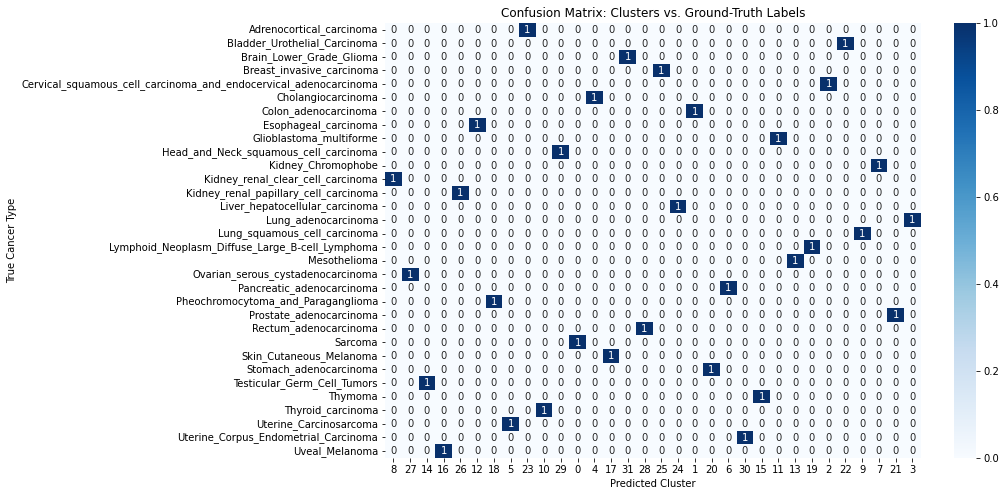

Adjusted Rand Index (ARI): 1.0000


In [3]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import seaborn as sns
import pandas as pd
import os

# Step 1: Map image paths to ground-truth labels
image_paths = test_dataset.samples  # Access image paths from dataset
ground_truth_labels = [os.path.basename(os.path.dirname(p)) for p, _ in image_paths]  # Folder names as labels

# Step 2: Map each image to its predicted cluster
predicted_clusters = clusters  # Use clusters from the K-Means output

# Step 3: Create a DataFrame to organize predictions and labels
df = pd.DataFrame({
    "Image": [os.path.basename(p) for p, _ in image_paths],
    "True_Label": ground_truth_labels,
    "Cluster": predicted_clusters
})

# Step 4: Encode ground-truth labels numerically for comparison
true_labels_encoded = pd.factorize(df["True_Label"])[0]  # Encode labels as integers

# Step 5: Create a confusion matrix
conf_matrix = confusion_matrix(true_labels_encoded, df["Cluster"])

# Step 6: Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=df["Cluster"].unique(),
            yticklabels=pd.factorize(df["True_Label"])[1])  # Decode labels for axis
plt.title("Confusion Matrix: Clusters vs. Ground-Truth Labels")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cancer Type")
plt.show()

# Step 7: Evaluate clustering performance using Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels_encoded, df["Cluster"])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")